In [54]:
import pandas as pd
import numpy as np
import random
import datetime
import matplotlib.pyplot as plt
import statsmodels.api as sm
from tqdm import tqdm
import xgboost as xgb
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import classification_report, confusion_matrix

In [229]:
def formatBacktestdata(_ccy:str):
    # Formatting
    _tarCol = ['Open time', 'Open', 'High', 'Low', 'Volume', 'Close']
    _Dir = "C:\\Users\\LCYY\\Desktop\\CrytoTrade\\Data\\Binance\\"
    _filename = '{}USDT.csv'.format(_ccy)
    _histData = pd.read_csv(_Dir + _filename, dtype={'Open time':str})[_tarCol].dropna()
    _histData['datetime'] = pd.to_datetime(_histData['Open time'], format='%Y-%m-%d %H:%M:%S')
    _histData = _histData.sort_values('datetime').reset_index(drop=True)
    _histData['date'] = _histData.datetime.dt.date
    _histData['time'] = _histData.datetime.dt.time
    _histData['symbol'] = _ccy + '/' + 'USDT'
    _histData = _histData[['datetime', 'date', 'time', 'symbol'] + _tarCol]
    _histData = _histData.drop(columns=['Open time'], axis=1)
    return _histData
    
def getRandomPeriod(_date:list, _numDays:int):
    _minDate = datetime.date(2020, 12, 31)
    _maxDate = datetime.date(2021, 10, 31)
    _startPeriod = random.choice(_date)
    _endPeriod = _startPeriod + datetime.timedelta(days=_numDays)
    if (_startPeriod >= _minDate) and (_endPeriod <= _maxDate) :
        return _startPeriod, _endPeriod
    else:
        return getRandomPeriod(_date, _numDays)

In [260]:
def Gen_Y(_close:pd.Series, _numPeriod:int):
    _closelag = (_close.shift(1)/_close)-1
    _execCost = abs(_closelag[_closelag < 0].mean()) * 0.5
    _Fore = pd.DataFrame(_close, columns=['Close'])
    _outY = []
    for i in range(1, _numPeriod+1):
        _Fore['Fwd_{}'.format(i)] = (((_Fore['Close'].shift(-i)/_Fore['Close'])-1))
    _Y = (_Fore.drop(['Close'], axis=1) > _execCost).sum(axis=1).apply(lambda x: 1 if x > 0 else 0)
    return _Y
    
def Gen_backtesting_data(_ccy:str, _scalpWindow:int):
    # Load data
    _data = formatBacktestdata(_ccy)
    #_startDate, _endDate = getRandomPeriod(_date=_data.date.unique(), _numDays=90)
    _TrainStartDate, _TrainEndDate = datetime.date(2020, 12, 31), datetime.date(2021, 10, 31) 
    _TestStartDate, _TestEndDate = datetime.date(2021, 10, 31), datetime.date(2021, 12, 1) 
    _train = _data[(_data.date >= _TrainStartDate) & (_data.date <= _TrainEndDate)].reset_index(drop=True)
    _test = _data[(_data.date >= _TestStartDate) & (_data.date <= _TestEndDate)].reset_index(drop=True)
    for data in [_train, _test]:
        # Normalization
        # Return Lag
        for _lag in [1, 2, 3, 4, 5, 7, 14, 28]:
            data['Return_LAG_{}'.format(_lag)] = (data.Close/data.Close.shift(_lag)-1)
        # Realized Volatility
        for _rv in [15, 30, 60, 180, 360, 720, 1440]:
            ann_factor = 1440 * 365 / _rv
            data['RealizedVol_Window_{}'.format(_rv)] = np.sqrt(np.square(data.Return_LAG_1).rolling(_rv).sum().clip(0,None) \
                *ann_factor)
        # ADTV
        for _adtv in [3, 5, 15, 30, 60, 180, 360, 1440]:
            data['ADTV_{}'.format(_adtv)] = data.Volume.rolling(window=_adtv).mean().shift(1)
        # Y
        _execCost = 0.0005
        data['Actual_Y'] = Gen_Y(_close=_data.Close, _numPeriod=_scalpWindow)
    # Cut First and Last Day
    _train = _train[(_train.date > _TrainStartDate) & (_train.date < _TrainEndDate)].reset_index(drop=True)
    _test = _test[(_test.date > _TestStartDate) & (_test.date < _TestEndDate)].reset_index(drop=True)
    return _train, _test
    
def Gen_backtesting_signal_cont(_data:pd.DataFrame):
    # Signal
    _signaldf = pd.DataFrame(data=[x for x in _data.date], columns=['date'])
    _signaldf['time'] = _data.time
    # Return Lag
    for _lag in [1, 2, 3, 4, 5, 7, 14, 28]:
        _signaldf['Return_LAG_{}'.format(_lag)] = _data['Return_LAG_{}'.format(_lag)]
    # Realized Volatility
    RV_scaled = pd.DataFrame(preprocessing.StandardScaler().fit_transform(_data[_data.columns[['RealizedVol' \
                      in col for col in _data.columns]]]), columns=_data[_data.columns[['RealizedVol' in \
                          col for col in _data.columns]]].columns)
    # ADTV
    ADTV_scaled = pd.DataFrame(preprocessing.StandardScaler().fit_transform(_data[_data.columns[['ADTV' \
                      in col for col in _data.columns]]]), columns=_data[_data.columns[['ADTV' in \
                          col for col in _data.columns]]].columns)
    _signaldf = pd.concat([_signaldf, RV_scaled, ADTV_scaled], axis=1)
    # Y
    _signaldf['Actual_Y'] = _data['Actual_Y']
    
    return _signaldf

def GetSellingPrice(_buysignal:int, _buyPx:float, _close1:float, _close2:float, _close3:float):
    if _buysignal == 1:
        if _close1 > _buyPx:
            return _close1
        elif _close2 > _buyPx:
            return _close2
        else:
            return _close3
    else:
        return 0

In [261]:
def vifcl(df:pd.DataFrame):
    a = 0
    i = 0
    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    vif["features"] = df.columns
    t = vif["VIF Factor"].max()
    for each in vif["VIF Factor"]:
        if each == t and each >= 10:
            a = i
        i += 1
    vax = vif["VIF Factor"].loc[a]
    #print(vif.loc[a],"\n>10")
    return a,vax
    
def runVIF(df:pd.DataFrame):
    # Raw train/test for VIF
    _VIF_X = df.drop(['date', 'time', 'Actual_Y'], axis=1)
    _VIF_y = df['Actual_Y']
    # First Fit
    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(_VIF_X.values, i) for i in range(_VIF_X.shape[1])]
    vif["features"] = _VIF_X.columns
    vif.round(1)
    # Drop VIF>10
    dropcindex=[]
    while True:
        vmax = 0
        dropt = False
        k,s = vifcl(_VIF_X)
        if s >= 10:
            dropt = True
        if dropt == True:
            #print("dropped",_VIF_X.columns[k])
            dropcindex.append(_VIF_X.columns[k])
            _VIF_X = _VIF_X.drop([_VIF_X.columns[k]],axis=1)
            vif = vif.drop([k])
            _VIF_X = _VIF_X.reset_index(drop=True)
            vif = vif.reset_index(drop=True)
        else:
            break
    return dropcindex

In [267]:
# Param
_dataDict = {}
_scalpingWindow = 3
_ccyList = ['BTC', 'ETH', 'SOL']
# Backtesting
for _ccy in tqdm(_ccyList):
    _dataDict[_ccy] = {}
    _dataDict[_ccy]['Train'], _dataDict[_ccy]['Test'] = Gen_backtesting_data(_ccy=_ccy, _scalpWindow=_scalpingWindow)
    # Normalization
    _dataDict[_ccy]['NormalizedTrain'], _dataDict[_ccy]['NormalizedTest'] = \
        Gen_backtesting_signal_cont(_data=_dataDict[_ccy]['Train']), Gen_backtesting_signal_cont(_data=_dataDict[_ccy]['Test'])
    # VIF
    _dataDict[_ccy]['VIFExcluded'] = runVIF(_dataDict[_ccy]['NormalizedTrain'])
    _dataDict[_ccy]['VIFIncluded'] = _dataDict[_ccy]['NormalizedTrain'].columns \
        [~_dataDict[_ccy]['NormalizedTrain'].columns.isin(_dataDict[_ccy]['VIFExcluded'])]
    _dataDict[_ccy]['NVIFTrain'] = _dataDict[_ccy]['NormalizedTrain'][_dataDict[_ccy]['VIFIncluded']]
    _dataDict[_ccy]['NVIFTest'] = _dataDict[_ccy]['NormalizedTest'][_dataDict[_ccy]['VIFIncluded']]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [14:27<00:00, 289.32s/it]


In [276]:
# LOGI
# Post VIF fit
_tarCcy = 'BTC'
_trainX = _dataDict[_tarCcy]['NVIFTrain'].drop(['date', 'time', 'Actual_Y'], axis=1)
_trainy = _dataDict[_tarCcy]['NVIFTrain']['Actual_Y']
_testX = _dataDict[_tarCcy]['NVIFTest'].drop(['date', 'time', 'Actual_Y'], axis=1)
_testy = _dataDict[_tarCcy]['NVIFTest']['Actual_Y']
# Constant
#_trainX = sm.add_constant(_trainX)
#_testX = sm.add_constant(_testX)
model = sm.Logit(_trainy, _trainX)
logi = model.fit(solver='lbfgs', max_iter=1000, C=1e9)
print('Training Data')
display(logi.summary())
display(confusion_matrix(_trainy, (logi.predict(_trainX) >= 0.5).astype(int)))
print(classification_report(_trainy, (logi.predict(_trainX) >= 0.5).astype(int)))
print('Testing Data')
display(confusion_matrix(_testy, (logi.predict(_testX) >= 0.5).astype(int)))
print(classification_report(_testy, (logi.predict(_testX) >= 0.5).astype(int)))

Optimization terminated successfully.
         Current function value: 0.684671
         Iterations 5
Training Data


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Actual_Y   No. Observations:               435327
Model:                          Logit   Df Residuals:                   435311
Method:                           MLE   Df Model:                           15
Date:                Wed, 08 Dec 2021   Pseudo R-squ.:                 0.01044
Time:                        02:56:35   Log-Likelihood:            -2.9806e+05
converged:                       True   LL-Null:                   -3.0120e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Return_LAG_1              14.9423      3.380      4.421      0.000       8.318      21.566
Return_LAG_2             -16.8485      3.377     -4.989      0.000     -23.468     -10.229
Return_LAG_3               2.1043      3.375      0.624      0.533      -4.510       8.719
Return_LAG_4               1.8596      3.365      0.553      0.581      -4.736       8.456
Return_LAG_5               9.6825      2.868      3.376      0.001       4.061      15.304
Return_LAG_7             -27.6375      1.854    -14.905      0.000     -31.272     -24.003
Return_LAG_14              5.1562      1.097      4.701      0.000       3.006       7.306
Return_LAG_28            -17.8182      0.652    -27.326      0.000     -19.096     -16.540
RealizedVol_Window_15      0.1098      0.008     14.511      0.000       0.095       0.125
RealizedVol_Window_180     0.0558      0.008      6.666      0.000       0.039       0.072
RealizedVol_Window_720     0.0029      0.009      0.335      0.738      -0.014       0.020
ADTV_3                     0.0351      0.006      6.285      0.000       0.024       0.046
ADTV_15                   -0.0228      0.009     -2.611      0.009      -0.040      -0.006
ADTV_60                    0.0277      0.007      3.730      0.000       0.013       0.042
ADTV_360                  -0.0133      0.007     -1.860      0.063      -0.027       0.001
ADTV_1440                  0.0777      0.007     11.684      0.000       0.065       0.091
==========================================================================================
"""

array([[145865,  60907],
       [133934,  94621]], dtype=int64)

              precision    recall  f1-score   support

           0       0.52      0.71      0.60    206772
           1       0.61      0.41      0.49    228555

    accuracy                           0.55    435327
   macro avg       0.56      0.56      0.55    435327
weighted avg       0.57      0.55      0.54    435327

Testing Data


array([[10639,  7285],
       [15352,  9924]], dtype=int64)

              precision    recall  f1-score   support

           0       0.41      0.59      0.48     17924
           1       0.58      0.39      0.47     25276

    accuracy                           0.48     43200
   macro avg       0.49      0.49      0.48     43200
weighted avg       0.51      0.48      0.47     43200



Training Data


array([[ 93420, 113352],
       [ 72301, 156254]], dtype=int64)

              precision    recall  f1-score   support

           0       0.56      0.45      0.50    206772
           1       0.58      0.68      0.63    228555

    accuracy                           0.57    435327
   macro avg       0.57      0.57      0.56    435327
weighted avg       0.57      0.57      0.57    435327



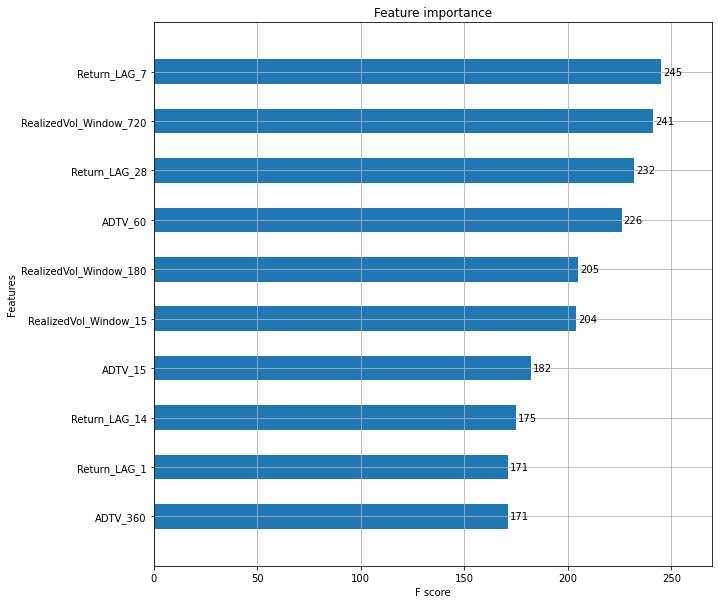

Testing Data


array([[ 6836, 11088],
       [10072, 15204]], dtype=int64)

              precision    recall  f1-score   support

           0       0.40      0.38      0.39     17924
           1       0.58      0.60      0.59     25276

    accuracy                           0.51     43200
   macro avg       0.49      0.49      0.49     43200
weighted avg       0.51      0.51      0.51     43200



In [277]:
# XGBoost
# Post VIF fit
_trainX = _dataDict[_tarCcy]['NVIFTrain'].drop(['date', 'time', 'Actual_Y'], axis=1)
_trainy = _dataDict[_tarCcy]['NVIFTrain']['Actual_Y']
_testX = _dataDict[_tarCcy]['NVIFTest'].drop(['date', 'time', 'Actual_Y'], axis=1)
_testy = _dataDict[_tarCcy]['NVIFTest']['Actual_Y']
fix_params = {'objective': 'binary:logistic', 'eval_metric':'mlogloss', \
              'colsample_bytree': 0.35, 'eta': 0.05, 'max_depth': 5, \
              'n_estimators': 100, 'subsample': 0.45, 'use_label_encoder':False}
xg_reg = xgb.XGBClassifier(**fix_params)
xg_reg.fit(_trainX, _trainy)
print('Training Data')
display(confusion_matrix(_trainy, xg_reg.predict(_trainX)))
print(classification_report(_trainy, xg_reg.predict(_trainX)))
fig, ax = plt.subplots(figsize=(10,10))
xgb.plot_importance(xg_reg, max_num_features=10, height=0.5, ax=ax,importance_type='weight')
plt.show()
print('Testing Data')
display(confusion_matrix(_testy, xg_reg.predict(_testX)))
print(classification_report(_testy, xg_reg.predict(_testX)))

In [278]:
# PnL
_initialNotional = 100000
_executionCost = 0.005
_predicted = pd.Series(xg_reg.predict(_testX), name='Buy_Signal')
_close = formatBacktestdata(_tarCcy)[(_data.date >= datetime.date(2021, 11, 1)) & \
            (_data.date <= datetime.date(2021, 12, 1))].reset_index(drop=True).Close
Plotdf = pd.concat([_dataDict[_tarCcy]['Test'].date, _dataDict[_tarCcy]['Test'].time, \
                    _dataDict[_tarCcy]['Test']['Close'], _predicted, _dataDict[_tarCcy]['Test']['Actual_Y']], axis=1)
# Buy Price
Plotdf['BuyPx'] = Plotdf.Close * Plotdf.Buy_Signal
for i in range(1, _scalpingWindow+1):
    Plotdf['Close_t+{}'.format(i)] = _close.shift(-i)[:len(Plotdf)]
# Selling Price
Plotdf['SellPx'] = Plotdf[['Buy_Signal', 'BuyPx', 'Close_t+1', 'Close_t+2', 'Close_t+3']].apply(lambda x: 
                        GetSellingPrice(_buysignal=x[0], _buyPx=x[1], _close1=x[2], _close2=x[3], _close3=x[4]), axis=1)
# Return
Plotdf['Implied Return (%)'] = (Plotdf['SellPx']/Plotdf['BuyPx']-1).fillna(0) * 100
Plotdf['MTM PnL (USD)'] = Plotdf['Implied Return (%)']/100 * _initialNotional
Plotdf['Realized PnL (USD)'] = Plotdf['Buy_Signal'] * (Plotdf['MTM PnL (USD)'] - abs(Plotdf['MTM PnL (USD)'] * _executionCost))
Plotdf['Realized Return (%)'] = Plotdf['Realized PnL (USD)']/_initialNotional * 100
Plotdf['CumReturn'] = (Plotdf['Realized Return (%)']/100+1).cumprod()-1

In [279]:
Plotdf

,date,time,Close,Buy_Signal,Actual_Y,BuyPx,Close_t+1,Close_t+2,Close_t+3,SellPx,Implied Return (%),MTM PnL (USD),Realized PnL (USD),Realized Return (%),CumReturn
0,2021-11-01,00:00:00,60491.21,1,0,60491.21,60509.26,60530.81,60454.26,60509.26,0.029839,29.839046,29.689851,0.029690,0.000297
1,2021-11-01,00:01:00,60509.26,1,0,60509.26,60530.81,60454.26,60521.41,60530.81,0.035614,35.614384,35.436312,0.035436,0.000651
2,2021-11-01,00:02:00,60530.81,1,1,60530.81,60454.26,60521.41,60469.29,60469.29,-0.101634,-101.634193,-102.142364,-0.102142,-0.000371
3,2021-11-01,00:03:00,60454.26,1,1,60454.26,60521.41,60469.29,60487.04,60521.41,0.111076,111.075712,110.520334,0.110520,0.000734
4,2021-11-01,00:04:00,60521.41,1,1,60521.41,60469.29,60487.04,60469.86,60469.86,-0.085176,-85.176469,-85.602351,-0.085602,-0.000123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43195,2021-11-30,23:55:00,57627.15,1,0,57627.15,57697.33,57764.45,57626.21,57697.33,0.121783,121.782875,121.173961,0.121174,0.139443
43196,2021-11-30,23:56:00,57697.33,1,0,57697.33,57764.45,57626.21,57238.84,57764.45,0.116331,116.331206,115.749550,0.115750,0.140762
43197,2021-11-30,23:57:00,57764.45,1,0,57764.45,57626.21,57238.84,57408.55,57408.55,-0.616123,-616.122892,-619.203507,-0.619204,0.133699
43198,2021-11-30,23:58:00,57626.21,1,1,57626.21,57238.84,57408.55,57253.00,57253.00,-0.647639,-647.639329,-650.877526,-0.650878,0.126320


In [215]:
_data = formatBacktestdata('SOL')
_closelag = (_data.Close.shift(1)/_data.Close)-1
_execCost = abs(_closelag[_closelag < 0].mean())

In [216]:
_execCost

0.001660569674245275

In [218]:
_closelag.mean()+_closelag.std()

0.0025627128248379314

In [225]:
abs(_closelag[_closelag > 0].mean())

0.0016572464239944656

In [224]:
np.floor(0.001660569674245275*100000)/100000

0.00166